In [6]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data description

For this data science challenge, you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format

Define basic functions to append individual files to a dataframe for ease of analysis. 

In [1]:
import os 
path = os.getcwd()+"/cabspottingdata/"
path

'/Users/sreetama/Desktop/PMI-cab-SF/cabspottingdata/'

In [2]:
all_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.txt')]
print(f'Total number of taxis {len(all_files)}')


Total number of taxis 537


To get miles between 2 geo-locations using the lat longs, Havershine distance https://en.wikipedia.org/wiki/Haversine_formula is used - it determines the great-circle distance between two points on a sphere given their longitudes and latitudes. It an improvement over euclidean distance (given earth is not flat, but within a city may not have a big effect either!) - its still an approximation (likely an under estimation) of actual distance travelled by taxi between 2 geo locations...but the best that can be done at the moment without actual route data.

In [3]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(row):
    #function to compute havershine distance
    lon1 = row['long_start']
    lat1 = row['lat_start']
    lon2 = row['long_end']
    lat2 = row['lat_end']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    dist_miles = 3959.87433  * c
    return dist_miles


In [4]:
def process_cab_data(raw_data):
    # function to preprocess the rawdata and add columns extracted from them
    raw_data = raw_data.rename(columns={0: 'lat', 1: 'long', 2:'occupied', 3:'timestamp'})
    raw_data['date_time'] = pd.to_datetime(raw_data['timestamp'], unit='s')
    raw_data.drop('timestamp', axis=1, inplace=True)
    raw_data.occupied=raw_data.occupied.astype(bool)
    raw_data = raw_data.reset_index()
    raw_data['prevlat'] = raw_data.shift(1)['lat']
    raw_data['prevlong'] = raw_data.shift(1)['long']
    raw_data = raw_data.dropna()
    raw_data['trip_num'] = raw_data['occupied'].diff().cumsum().fillna(0)
    
    result = raw_data.groupby(['trip_num']).agg({'date_time':[('trip_start_time','first'), ('trip_end_time','last')], 
                                                 'lat':[('lat_start','first'), ('lat_end','last')], 
                                                 'long':[('long_start', 'first'), ('long_end', 'last')],
                                                 'occupied':[('occupied_status','first')],
                                                 'prevlat':[('prevlat','first')],
                                                 'prevlong':[('prevlong','first')]})
    #result.columns = result.unstack()
    result.columns = result.columns.droplevel(0)
    result.reset_index(inplace=True)
    
    #compute haversine distance
    result['trip_distance_miles'] = result.apply(lambda row: haversine(row), axis=1)
    
    #compute trip day and time
    result['trip_day_of_week'] = result['trip_start_time'].dt.strftime('%A')
    result['trip_hour'] = result['trip_start_time'].dt.hour
        
    # compute trip duration
    #result['trip_time_mins'] = (result['trip_end_time']-result['trip_start_time'])/60

    return(result)


In [7]:
raw_data = pd.read_csv(os.path.join(path, "new_uvreoipy.txt"), sep=' ', header=None)
raw_data= raw_data.rename(columns={0: 'lat', 1: 'long', 2:'occupied', 3:'timestamp'})
raw_data

,lat,long,occupied,timestamp
0,37.78475,-122.42145,0,1211018476
1,37.78556,-122.41585,0,1211018523
2,37.78623,-122.41080,0,1211018583
3,37.78662,-122.40722,0,1211018644
4,37.78693,-122.40473,0,1211018715
...,...,...,...,...
22264,37.74654,-122.44338,1,1213035491
22265,37.75140,-122.44296,1,1213035548
22266,37.75686,-122.44239,1,1213035612
22267,37.76047,-122.44215,1,1213035668


In [8]:
raw_data = pd.read_csv(os.path.join(path, "new_uvreoipy.txt"), sep=' ', header=None)
df_new = process_cab_data(raw_data)
df_new.head()

,trip_num,trip_start_time,trip_end_time,lat_start,lat_end,long_start,long_end,occupied_status,prevlat,prevlong,trip_distance_miles,trip_day_of_week,trip_hour
0,0.0,2008-05-17 10:02:03,2008-05-17 15:56:15,37.78556,37.79497,-122.41585,-122.40084,False,37.78475,-122.42145,1.046438,Saturday,10
1,1.0,2008-05-17 15:56:59,2008-05-17 16:15:29,37.79498,37.61570,-122.40079,-122.39156,True,37.79497,-122.40084,12.400825,Saturday,15
2,2.0,2008-05-17 16:15:36,2008-05-17 16:59:52,37.61535,37.61648,-122.39259,-122.38601,False,37.61570,-122.39156,0.368595,Saturday,16
3,3.0,2008-05-17 17:31:40,2008-05-17 17:53:08,37.61609,37.78482,-122.38849,-122.40377,True,37.61648,-122.38601,11.691307,Saturday,17
4,4.0,2008-05-17 17:53:54,2008-05-17 18:03:25,37.78509,37.78567,-122.40458,-122.40607,False,37.78482,-122.40377,0.090721,Saturday,17


In [46]:
# reads in and appends all individual taxi trace files into 1 dataframe
# this executes for a while
Taxidata = pd.DataFrame()

for taxi in all_files:
    #print(taxi)
    df = pd.read_csv(os.path.join(path, taxi), sep=' ', header=None)
    record = process_cab_data(df)
    record["TaxiID"]=taxi
    #print(record)
    Taxidata=pd.concat([Taxidata,record])

In [47]:
Taxidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928277 entries, 0 to 1624
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_num             928277 non-null  float64       
 1   trip_start_time      928277 non-null  datetime64[ns]
 2   trip_end_time        928277 non-null  datetime64[ns]
 3   lat_start            928277 non-null  float64       
 4   lat_end              928277 non-null  float64       
 5   long_start           928277 non-null  float64       
 6   long_end             928277 non-null  float64       
 7   occupied_status      928277 non-null  bool          
 8   prevlat              928277 non-null  float64       
 9   prevlong             928277 non-null  float64       
 10  trip_distance_miles  928277 non-null  float64       
 11  trip_day_of_week     928277 non-null  object        
 12  trip_hour            928277 non-null  int64         
 13  TaxiID          

In [48]:
Taxidata.head()

,trip_num,trip_start_time,trip_end_time,lat_start,lat_end,long_start,long_end,occupied_status,prevlat,prevlong,trip_distance_miles,trip_day_of_week,trip_hour,TaxiID
0,0.0,2008-05-17 14:26:38,2008-05-17 15:52:58,37.79596,37.78705,-122.26824,-122.41098,False,37.79826,-122.26613,7.820190,Saturday,14,new_adkavy.txt
1,1.0,2008-05-17 15:53:13,2008-05-17 16:12:02,37.78726,37.61468,-122.41110,-122.38974,True,37.78705,-122.41098,11.984549,Saturday,15,new_adkavy.txt
2,2.0,2008-05-17 16:12:19,2008-05-17 16:59:08,37.61467,37.61656,-122.38975,-122.38590,False,37.61468,-122.38974,0.247966,Saturday,16,new_adkavy.txt
3,3.0,2008-05-17 17:44:27,2008-05-17 18:05:40,37.61464,37.78578,-122.39350,-122.42814,True,37.61656,-122.38590,11.978692,Saturday,17,new_adkavy.txt
4,4.0,2008-05-17 18:05:42,2008-05-17 18:13:24,37.78583,37.78632,-122.42816,-122.43902,False,37.78578,-122.42814,0.594141,Saturday,18,new_adkavy.txt


In [49]:
Taxidata.describe()

,trip_num,lat_start,lat_end,long_start,long_end,prevlat,prevlong,trip_distance_miles,trip_hour
count,928277.000000,928277.000000,928277.000000,928277.000000,928277.000000,928277.000000,928277.000000,928277.000000,928277.000000
mean,965.289086,37.772493,37.772394,-122.416630,-122.416574,37.772408,-122.416579,1.986447,10.390424
std,626.050841,0.048692,0.048732,0.028053,0.028338,0.048703,0.028324,3.466603,7.396586
min,0.000000,34.710520,34.710520,-125.334310,-126.167150,34.710520,-126.167150,0.000000,0.000000
25%,442.000000,37.770100,37.770070,-122.429270,-122.429250,37.770070,-122.429250,0.352241,4.000000
50%,908.000000,37.785720,37.785730,-122.414190,-122.414190,37.785730,-122.414190,0.933538,8.000000
75%,1425.000000,37.792760,37.792740,-122.403770,-122.403730,37.792740,-122.403740,1.922431,17.000000
max,4288.000000,50.305460,50.305460,-122.000020,-122.000700,50.305460,-122.000700,865.757318,23.000000


In [50]:
Taxidata.shape

(928277, 14)

In [51]:
Taxidata.to_csv("Taxidata.csv")

In [52]:
tempDF=Taxidata

# Q1: calculate the potential for a yearly reduction in CO2 emissions

### caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

In [53]:
UnoccupiedTaxi = Taxidata[Taxidata['occupied_status'] == False]
#Average unoccupied monthly trip distance of taxi
MonthlyUnoccupiedDist = UnoccupiedTaxi.groupby(by=['TaxiID'])['trip_distance_miles'].sum().sum()
MonthlyUnoccupiedDist

680365.9918992601

In [54]:
# here we assume the 537 taxis represent the entire fleet of which each month 15% are converting 
# from combustion to electric engines for the following calculation
TaxiCount=537
AnnualTotalUnoccupiedDist = 12*MonthlyUnoccupiedDist
#  average passenger vehicle emits about 404 grams of CO2 per mile
#AvgCO2perMile=404
#AnnualCO2emission = AnnualTotalUnoccupiedDist*AvgCO2perMile
#print(f'Annual Co2 emmission for SF taxi fleet for unoccupied hours is {(AnnualCO2emission)}')
AnnualTotalUnoccupiedDist

8164391.902791121

In [55]:
#assume at month 0 all taxis are combustion engine and then starts converting to EV at 15% per month, 
# thus MonthlyUnoccupiedDist reduces at uniform 15% per subsequent month
CombinedUnoccupiedDistEV=0
for month in range(12):
    CombinedUnoccupiedDistEV += MonthlyUnoccupiedDist
    MonthlyUnoccupiedDist=MonthlyUnoccupiedDist*0.85
    print(CombinedUnoccupiedDistEV)
    
AvgCO2perMile =404    
AnnualCO2emissionEV = CombinedUnoccupiedDistEV*AvgCO2perMile
print(f'Annual Co2 emmission for SF taxi fleet with 15% conversion to EV for unoccupied hours is {(AnnualCO2emissionEV)}')
     

680365.9918992601
1258677.0850136313
1750241.5141608466
2168071.2789359796
2523226.5789948427
2825108.5840448765
3081708.288337405
3299818.036986054
3485211.323337406
3642795.616736055
3776742.2661249065
3890596.9181054304
Annual Co2 emmission for SF taxi fleet with 15% conversion to EV for unoccupied hours is 1571801154.914594


In [56]:
EstimatedCO2Reduction = ((AnnualTotalUnoccupiedDist - CombinedUnoccupiedDistEV)/ AnnualTotalUnoccupiedDist)*100

print(f'Estimated annual Co2 reduction {EstimatedCO2Reduction} %')

Estimated annual Co2 reduction 52.34676428534291 %


# EDA

In [57]:
Taxidata.groupby('occupied_status')["trip_distance_miles"].describe()
# Max seems susspiciously high

,count,mean,std,min,25%,50%,75%,max
occupied_status,,,,,,,,
False,464244.0,1.465535,2.962875,0.0,0.130850,0.483822,1.210984,214.312460
True,464033.0,2.507596,3.835946,0.0,0.789685,1.387589,2.394571,865.757318


In [58]:
# check distance at 95, 99 and 999 percentiles
Taxidata["trip_distance_miles"].quantile([.9,0.99,0.9999])

0.9000     4.506712
0.9900    12.875336
0.9999    34.604712
Name: trip_distance_miles, dtype: float64

In [59]:
Taxidata["trip_distance_miles"].max()

865.7573180359338

/Users/sreetama/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance_miles', ylabel='Density'>

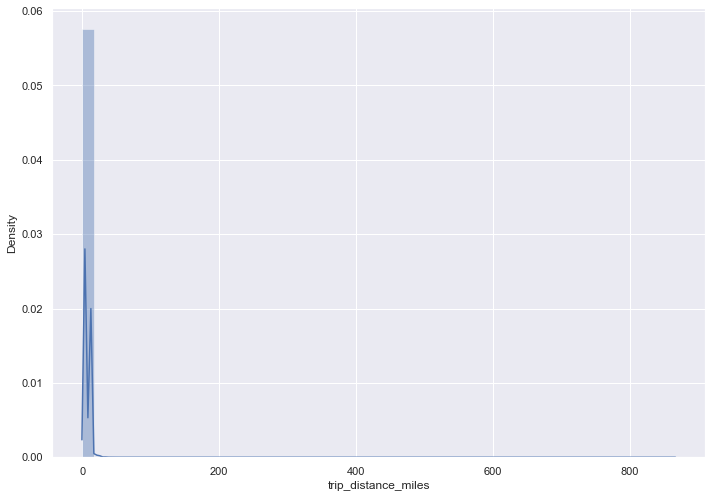

In [60]:
sns.distplot((Taxidata["trip_distance_miles"]))
# visualization shows data id not skewed distribution rather affected by outliers - 
# hence rather than take a log transform of variable, drop rows above the 99 percentile

In [61]:
# rows before filtering
Taxidata.shape

(928277, 14)

In [62]:
# Drop rows above the 999 percentile
Taxidata=Taxidata[Taxidata.trip_distance_miles < np.percentile(Taxidata.trip_distance_miles,99)]

In [63]:
# rows after filtering
Taxidata.shape

(918994, 14)

In [64]:
928277-918994

9283

In [65]:
Taxidata.groupby('occupied_status')["trip_distance_miles"].describe()

,count,mean,std,min,25%,50%,75%,max
occupied_status,,,,,,,,
False,461090.0,1.352608,2.562804,0.0,0.129031,0.478002,1.185206,12.875293
True,457904.0,2.321793,2.906527,0.0,0.782389,1.369548,2.335078,12.875315


array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

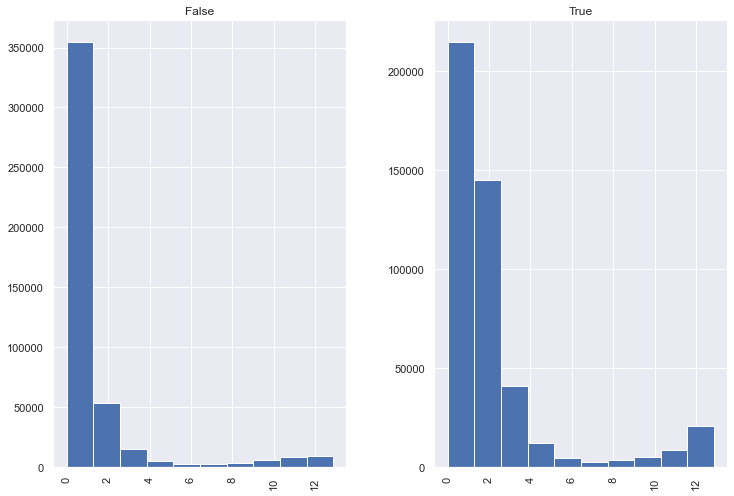

In [66]:
Taxidata["trip_distance_miles"].hist(by=Taxidata["occupied_status"])
#df['N'].hist(by=df['Letter'])
# this shows the same as above but with actual counts on the y axis

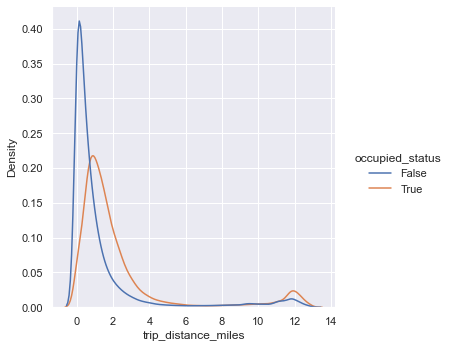

In [67]:
sns.displot(Taxidata, x="trip_distance_miles", hue="occupied_status", kind="kde" )

<AxesSubplot:xlabel='occupied_status', ylabel='trip_distance_miles'>

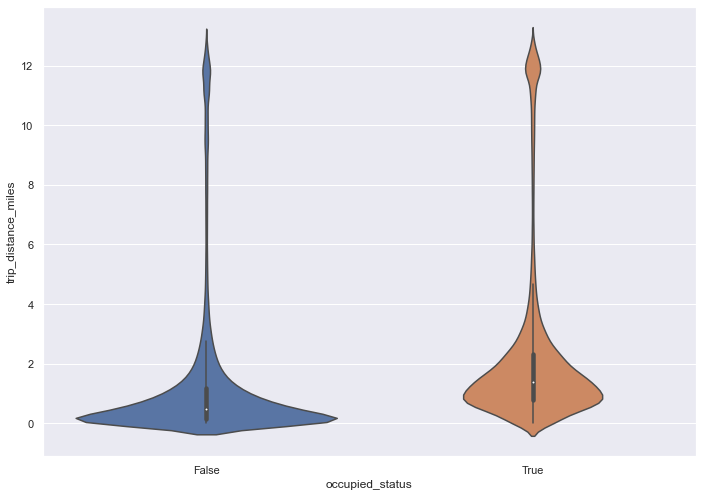

In [68]:
sns.violinplot(x="occupied_status", y="trip_distance_miles", data=Taxidata)

<AxesSubplot:xlabel='trip_day_of_week', ylabel='trip_distance_miles'>

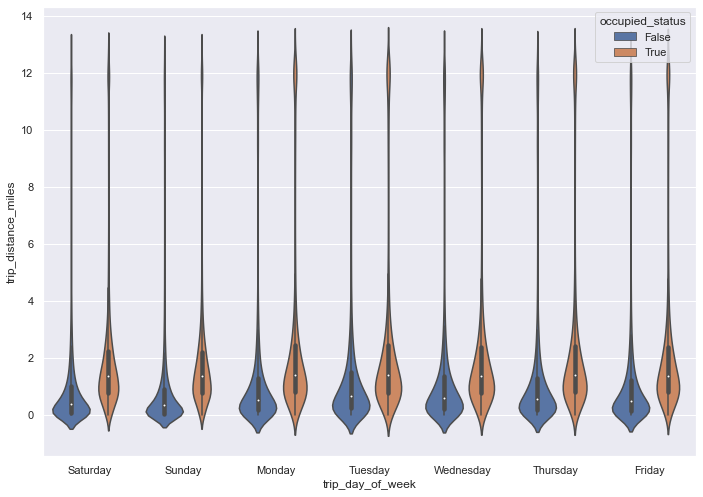

In [69]:
#sns.violinplot(x="occupied_status", y="trip_distance_miles",  data=Taxidata)
sns.violinplot(x="trip_day_of_week", y="trip_distance_miles",  hue ="occupied_status", data=Taxidata)
#sns.boxplot(x="continent", y="lifeExp", order=orderedContinents, data=gapminder)hue="occupied_status",palette="Set2",

In [70]:
Taxidata.groupby('occupied_status')["trip_distance_miles"].describe()

,count,mean,std,min,25%,50%,75%,max
occupied_status,,,,,,,,
False,461090.0,1.352608,2.562804,0.0,0.129031,0.478002,1.185206,12.875293
True,457904.0,2.321793,2.906527,0.0,0.782389,1.369548,2.335078,12.875315


In [71]:
Taxidata.groupby(['occupied_status','trip_day_of_week'])["trip_distance_miles"].describe()

count      mean       std  min       25%  \
occupied_status trip_day_of_week                                               
False           Friday            61726.0  1.400726  2.633017  0.0  0.142756   
                Monday            67062.0  1.545996  2.832900  0.0  0.157750   
                Saturday          80146.0  1.153239  2.327465  0.0  0.078911   
                Sunday            94769.0  1.016905  2.148264  0.0  0.045780   
                Thursday          55238.0  1.477854  2.648247  0.0  0.188922   
                Tuesday           49283.0  1.658922  2.818653  0.0  0.228487   
                Wednesday         52866.0  1.538730  2.709246  0.0  0.203568   
True            Friday            61328.0  2.435720  3.052036  0.0  0.793476   
                Monday            66469.0  2.540573  3.205446  0.0  0.786781   
                Saturday          79446.0  2.123958  2.603785  0.0  0.772155   
                Sunday            94221.0  2.024873  2.410156  0.0  0.781703   
                Thursday          54885.0  2.466081  3.094936  0.0  0.793346   
                Tuesday           48975.0  2.513410  3.173489  0.0  0.773751   
                Wednesday         52580.0  2.414237  3.054227  0.0  0.776183   

                                       50%       75%        max  
occupied_status trip_day_of_week                                 
False           Friday            0.485142  1.210671  12.871560  
                Monday            0.524572  1.285764  12.872560  
                Saturday          0.382326  1.014702  12.875293  
                Sunday            0.333621  0.902001  12.873372  
                Thursday          0.563934  1.306682  12.873355  
                Tuesday           0.659284  1.498751  12.869356  
                Wednesday         0.601037  1.373259  12.874031  
True            Friday            1.382412  2.387517  12.873411  
                Monday            1.388691  2.446127  12.874511  
                Saturday          1.349526  2.248612  12.874460  
                Sunday            1.351440  2.208666  12.874616  
                Thursday          1.391754  2.407472  12.873495  
                Tuesday           1.382702  2.447049  12.874580  
                Wednesday         1.363281  2.374574  12.875315

In [72]:
Weekly=Taxidata.groupby(['trip_day_of_week'])['occupied_status'].value_counts().reset_index(name="count")
#Weekly.columns=('trip_day_of_week','occupied_status','counts')
#df_long = pd.melt(Weekly, 'trip_day_of_week', var_name='occupied_status', value_name="Weekly")
#df_long
Weekly

,trip_day_of_week,occupied_status,count
0,Friday,False,61726
1,Friday,True,61328
2,Monday,False,67062
3,Monday,True,66469
4,Saturday,False,80146
5,Saturday,True,79446
6,Sunday,False,94769
7,Sunday,True,94221
8,Thursday,False,55238
9,Thursday,True,54885


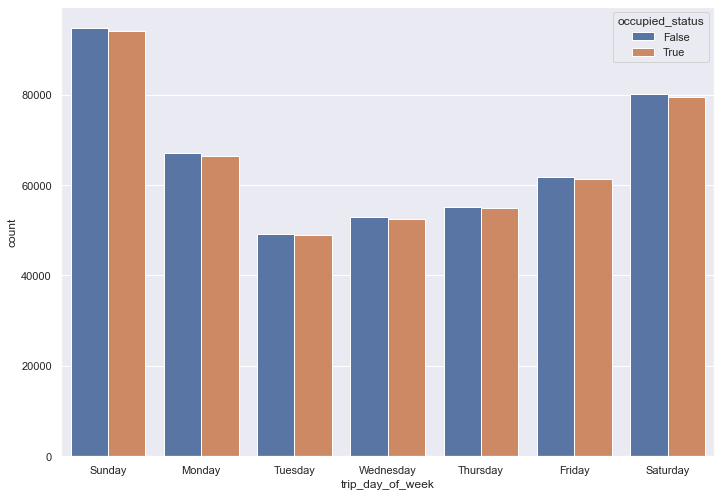

In [73]:
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
ax = sns.barplot(x="trip_day_of_week", y="count", hue="occupied_status", data=Weekly, order=order)

In [74]:
Daily=Taxidata.groupby(['trip_hour',"trip_day_of_week"])['occupied_status'].value_counts().reset_index(name="count")
Daily

,trip_hour,trip_day_of_week,occupied_status,count
0,0,Friday,True,2859
1,0,Friday,False,2684
2,0,Monday,True,3432
3,0,Monday,False,3330
4,0,Saturday,True,3157
...,...,...,...,...
331,23,Thursday,False,2299
332,23,Tuesday,False,2186
333,23,Tuesday,True,2149
334,23,Wednesday,True,2336


In [75]:
DailyT=Daily[Daily['occupied_status']==True]
DailyF=Daily[Daily['occupied_status']==False]

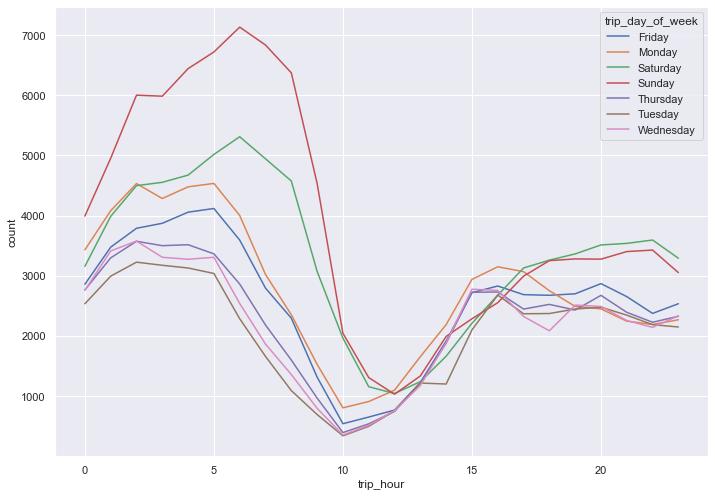

In [76]:
# plot hourly counts for occupied trips for all weekdays
ax = sns.lineplot(x="trip_hour", y="count", hue="trip_day_of_week", data=DailyT)

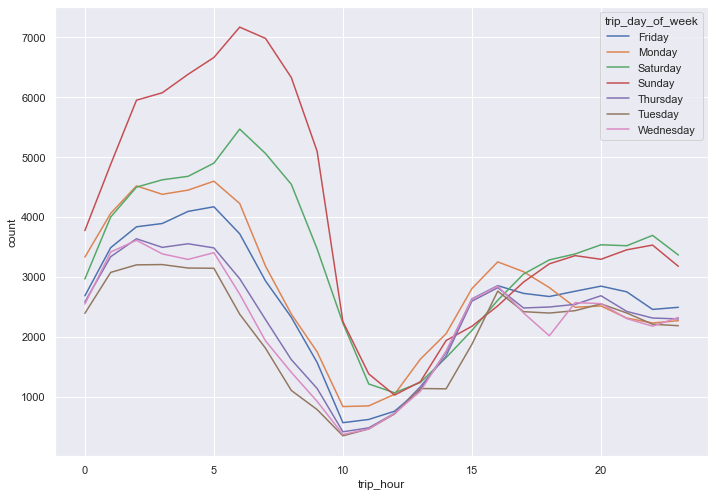

In [77]:
# plot hourly counts for unoccupied trips for all weekdays
ax = sns.lineplot(x="trip_hour", y="count", hue="trip_day_of_week", data=DailyF)

# Q2: Predict next pick up location

Here I build 2 models:
    1. predict the lat long based on features ()
    2. predict the probability of trip start given features ()
    3. [to do] generate hourly density maps of pickup locations 
    
[Noted for lat, long subtracting out the 37 and -122 has a big impact on model]

In [79]:
Taxidata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918994 entries, 0 to 1624
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_num             918994 non-null  float64       
 1   trip_start_time      918994 non-null  datetime64[ns]
 2   trip_end_time        918994 non-null  datetime64[ns]
 3   lat_start            918994 non-null  float64       
 4   lat_end              918994 non-null  float64       
 5   long_start           918994 non-null  float64       
 6   long_end             918994 non-null  float64       
 7   occupied_status      918994 non-null  bool          
 8   prevlat              918994 non-null  float64       
 9   prevlong             918994 non-null  float64       
 10  trip_distance_miles  918994 non-null  float64       
 11  trip_day_of_week     918994 non-null  object        
 12  trip_hour            918994 non-null  int64         
 13  TaxiID          

In [82]:
X_tmp = Taxidata.drop(['trip_num','trip_start_time','trip_end_time','trip_distance_miles','TaxiID','lat_end','long_end'], axis=1)

In [83]:
X_tmp['lat_start']=X_tmp['lat_start']-37
X_tmp['long_start']=X_tmp['long_start']-(-122)
X_tmp['prevlat']=X_tmp['prevlat']-37
X_tmp['prevlong']=X_tmp['prevlong']-(-122)

In [92]:
X_tmp.describe()

,lat_start,long_start,prevlat,prevlong,trip_hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000,918994.000000
mean,0.773470,-0.417241,0.773387,-0.417186,10.375655,0.133901,0.145301,0.173659,0.205649,0.119830,0.106919,0.114741
std,0.043694,0.024870,0.045856,0.025292,7.398068,0.340546,0.352405,0.378817,0.404175,0.324763,0.309011,0.318709
min,-2.289480,-2.168420,-2.289480,-4.167150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.770330,-0.429400,0.770310,-0.429380,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.785750,-0.414350,0.785760,-0.414340,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.792720,-0.403923,0.792710,-0.403880,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13.305460,-0.002040,13.305460,-0.002040,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
# Featurization convert the categorical trip_day_of_week to ohe-hot encoding
onehot= pd.get_dummies(X_tmp['trip_day_of_week'])
X_tmp.drop(['trip_day_of_week'], axis=1, inplace=True)
X_tmp=pd.concat([X_tmp, onehot], axis=1)

In [87]:
X_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918994 entries, 0 to 1624
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat_start        918994 non-null  float64
 1   long_start       918994 non-null  float64
 2   occupied_status  918994 non-null  bool   
 3   prevlat          918994 non-null  float64
 4   prevlong         918994 non-null  float64
 5   trip_hour        918994 non-null  int64  
 6   Friday           918994 non-null  uint8  
 7   Monday           918994 non-null  uint8  
 8   Saturday         918994 non-null  uint8  
 9   Sunday           918994 non-null  uint8  
 10  Thursday         918994 non-null  uint8  
 11  Tuesday          918994 non-null  uint8  
 12  Wednesday        918994 non-null  uint8  
dtypes: bool(1), float64(4), int64(1), uint8(7)
memory usage: 65.2 MB


Model 1: predict the lat long of next trip based on input features (last location, and time of day and week) 

In [91]:
y = X_tmp[['lat_start','long_start']]
X = X_tmp.drop(['lat_start','long_start'], axis=1) # dont put inplace=True
#y = X_tmp[['occupied_status']]
#X = X_tmp[['prevlat','prevlong', 'lat_start','long_start' ,'trip_day_of_week','trip_hour']]

In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918994 entries, 0 to 1624
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   occupied_status  918994 non-null  bool   
 1   prevlat          918994 non-null  float64
 2   prevlong         918994 non-null  float64
 3   trip_hour        918994 non-null  int64  
 4   Friday           918994 non-null  uint8  
 5   Monday           918994 non-null  uint8  
 6   Saturday         918994 non-null  uint8  
 7   Sunday           918994 non-null  uint8  
 8   Thursday         918994 non-null  uint8  
 9   Tuesday          918994 non-null  uint8  
 10  Wednesday        918994 non-null  uint8  
dtypes: bool(1), float64(2), int64(1), uint8(7)
memory usage: 51.2 MB


In [93]:
# modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score

# hyperparameter opimization
from sklearn.model_selection import GridSearchCV

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [96]:
forest = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1))

# Fitting
forest = forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# do a hyper-parameter optimization

In [113]:
# Evaluation
print("MAE on Train:{:.5f}".format(mean_absolute_error(y_train, y_train_pred)))
print("MAE on Test:{:.5f}".format(mean_absolute_error(y_test, y_test_pred)))
print("R2 score train:{:.2f}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{:.2f}".format(r2_score(y_test, y_test_pred)))
print("MAPE on Train:{:.5f}".format(mean_absolute_percentage_error(y_train, y_train_pred)))
print("MAPE on Test:{:.5f}".format(mean_absolute_percentage_error(y_test, y_test_pred)))
#y_Test_pred5 = knn.predict(X_Test)
#y_Test_pred5[5]

MAE on Train:0.00043
MAE on Test:0.00112
R2 score train:0.98
R2 score test:0.95
MAPE on Train:0.00092
MAPE on Test:0.00254


In [117]:
boosting = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))

# Fitting
boosting = boosting.fit(X_train, y_train)
y_train_pred2 = boosting.predict(X_train)
y_test_pred2 = boosting.predict(X_test)

In [118]:
# Evaluation
print("MAE on Train:{:.5f}".format(mean_absolute_error(y_train, y_train_pred2)))
print("MAE on Test:{:.5f}".format(mean_absolute_error(y_test, y_test_pred2)))
print("R2 score train:{:.2f}".format(r2_score(y_train, y_train_pred2)))
print("R2 score test:{:.2f}".format(r2_score(y_test, y_test_pred2)))
print("MAPE on Train:{:.5f}".format(mean_absolute_percentage_error(y_train, y_train_pred2)))
print("MAPE on Test:{:.5f}".format(mean_absolute_percentage_error(y_test, y_test_pred2)))
#y_Test_pred5 = knn.predict(X_Test)
#y_Test_pred5[5]

MAE on Train:0.00106
MAE on Test:0.00105
R2 score train:0.91
R2 score test:0.98
MAPE on Train:0.00224
MAPE on Test:0.00245


In [100]:
lr = MultiOutputRegressor(LinearRegression(n_jobs=1))

# Fitting
lr = lr.fit(X_train, y_train)
y_train_pred4 = lr.predict(X_train)
y_test_pred4 = lr.predict(X_test)

In [114]:
# Evaluation
print("MAE on Train:{:.5f}".format(mean_absolute_error(y_train, y_train_pred4)))
print("MAE on Test:{:.5f}".format(mean_absolute_error(y_test, y_test_pred4)))
print("R2 score train:{:.2f}".format(r2_score(y_train, y_train_pred4)))
print("R2 score test:{:.2f}".format(r2_score(y_test, y_test_pred4)))
print("MAPE on Train:{:.5f}".format(mean_absolute_percentage_error(y_train, y_train_pred4)))
print("MAPE on Test:{:.5f}".format(mean_absolute_percentage_error(y_test, y_test_pred4)))
#y_Test_pred5 = knn.predict(X_Test)
#y_Test_pred5[5]

MAE on Train:0.00279
MAE on Test:0.00278
R2 score train:0.84
R2 score test:0.83
MAPE on Train:0.00486
MAPE on Test:0.00468


In [102]:
knn = MultiOutputRegressor(KNeighborsRegressor())

# Fitting
knn = knn.fit(X_train, y_train)
y_train_pred5 = knn.predict(X_train)
y_test_pred5 = knn.predict(X_test)

In [115]:
# Evaluation
print("MAE on Train:{:.5f}".format(mean_absolute_error(y_train, y_train_pred5)))
print("MAE on Test:{:.5f}".format(mean_absolute_error(y_test, y_test_pred5)))
print("R2 score train:{:.2f}".format(r2_score(y_train, y_train_pred5)))
print("R2 score test:{:.2f}".format(r2_score(y_test, y_test_pred5)))
print("MAPE on Train:{:.5f}".format(mean_absolute_percentage_error(y_train, y_train_pred5)))
print("MAPE on Test:{:.5f}".format(mean_absolute_percentage_error(y_test, y_test_pred5)))
#y_Test_pred5 = knn.predict(X_Test)
#y_Test_pred5[5]

MAE on Train:0.00126
MAE on Test:0.00156
R2 score train:0.92
R2 score test:0.94
MAPE on Train:0.00282
MAPE on Test:0.00364


In [104]:
y_Test_pred5 = knn.predict(X_test)
y_Test_pred5[5]


array([ 0.750692, -0.468548])

In [109]:
y_test

,lat_start,long_start
1028,0.79502,-0.39744
986,0.79568,-0.42474
1103,0.80266,-0.41349
860,0.72064,-0.45309
923,0.78976,-0.39802
...,...,...
416,0.78840,-0.41338
212,0.79467,-0.40506
28,0.78500,-0.40867
9,0.79985,-0.42598


In [202]:
0.00105*53

0.05565

A degree of longitude is widest at the equator at 69.172 miles (111.321) and gradually shrinks to zero at the poles. At 40° north or south the distance between a degree of longitude is 53 miles (85 km) - this is applicable for SF at 37 degrees north latitude. therefore, a MAE of 0.00156 implies error of 0.08*0.08 miles square which is still a large area.

Model 2: predict the probability of start location being a pickup given features () 

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# evaluation metrics
from sklearn.metrics import accuracy_score

In [196]:
y = X_tmp[['occupied_status']]
X = X_tmp.drop(['occupied_status'], axis=1) # dont put inplace=True

In [197]:
y.shape

(918994, 1)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [201]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

# Fitting
forest = forest.fit(X_train, y_train)
y_train_predc = forest.predict(X_train)
y_test_predc = forest.predict(X_test)

# do a hyper-parameter optimization
print("Accuracy on Train:{:.2f}".format(accuracy_score(y_train, y_train_predc)))
print("Accuracy on Test:{:.2f}".format(accuracy_score(y_test, y_test_predc)))

/Users/sreetama/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy on Train:1.00
Accuracy on Test:0.67


In [199]:
GBM = GradientBoostingClassifier(n_estimators=100, random_state=1)

# Fitting
GBM = GBM.fit(X_train, y_train)
y_train_predGBM = GBM.predict(X_train)
y_test_predGBM = GBM.predict(X_test)

# do a hyper-parameter optimization
print("Accuracy on Train:{:.2f}".format(accuracy_score(y_train, y_train_predGBM)))
print("Accuracy on Test:{:.2f}".format(accuracy_score(y_test, y_test_predGBM)))

/Users/sreetama/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy on Train:0.61
Accuracy on Test:0.61


In [200]:
kNN = KNeighborsClassifier()

# Fitting
kNN = kNN.fit(X_train, y_train)
y_train_predkNN = kNN.predict(X_train)
y_test_predkNN = kNN.predict(X_test)

# do a hyper-parameter optimization
print("Accuracy on Train:{:.2f}".format(accuracy_score(y_train, y_train_predkNN)))
print("Accuracy on Test:{:.2f}".format(accuracy_score(y_test, y_test_predkNN)))

/Users/sreetama/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy on Train:0.75
Accuracy on Test:0.62


# Q3: Identify clusters of taxi cabs 

In [147]:
TaxiOccupied=Taxidata[Taxidata['occupied_status']==True]
TaxiUnOccupied=Taxidata[Taxidata['occupied_status']==False]

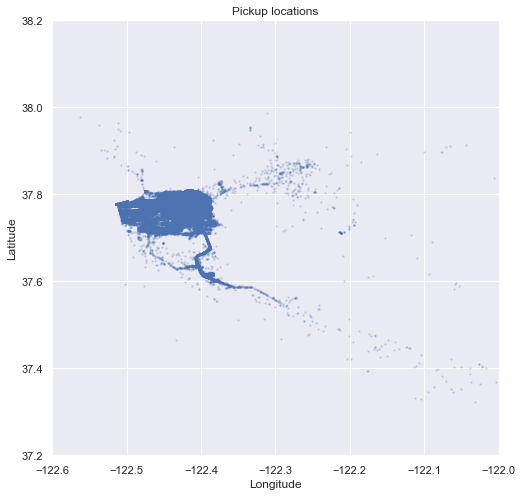

In [148]:
def pickup_scatter(t):
    plt.scatter(t['long_start'], t['lat_start'], s=2, alpha=0.2)
    plt.xlim(-122.6,-122)
    plt.ylim(37.2,38.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiOccupied)

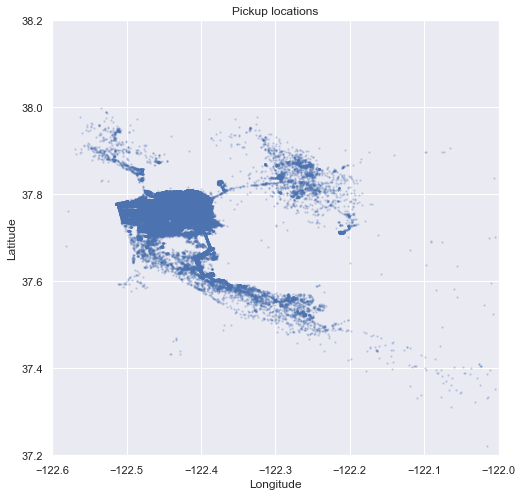

In [67]:
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiUnOccupied)

In [36]:
import folium
folium.__version__
#Creating a World Map
#world_map=folium.Map()
#world_map

'0.12.1.post1'

In [51]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# select a subset of 1000 points to run the clustering
#import random
#indices=random.sample(range(len(TaxiUnOccupied)), 1000)
# 
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
coords['clusterID'] = cluster_labels
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters of unoccupied taxis: {}'.format(num_clusters))

Number of clusters of unoccupied taxis: 5


In [47]:
coords

,lat_start,long_start,clusterID
364,37.77643,-122.39235,NaN
1796,37.79446,-122.39650,NaN
176,37.78745,-122.45278,NaN
40,37.79041,-122.40838,NaN
666,37.78181,-122.41897,NaN
...,...,...,...
716,37.79811,-122.44425,NaN
919,37.61794,-122.38586,NaN
1124,37.79522,-122.39895,NaN
1676,37.77586,-122.41869,NaN


In [75]:
latitude = 37.77
longitude= -122.42
sanmap = folium.Map(location=[latitude, longitude], zoom_start=12)
incidents = folium.map.FeatureGroup()

TaxiOccupied_sampled=TaxiOccupied.sample(300)

for lat, lng, in zip(TaxiOccupied_sampled.lat_start,TaxiOccupied_sampled.long_start):
    incidents.add_child(
    folium.CircleMarker(
    [lat, lng],
    radius=1, 
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.6
))
#latitudes = list(TaxiOccupied_sampled.lat_start)
#longitudes = list(TaxiOccupied_sampled.long_start)
#labels = list(TaxiOccupied_sampled.occupied_status)
#for lat, lng, label in zip(latitudes, longitudes, labels):
#    folium.Marker([lat,lng], popup=label).add_to(sanmap)    
sanmap.add_child(incidents)   
sanmap

In [214]:
TaxiOccupiedMorn=TaxiOccupied[TaxiOccupied['trip_hour'].between(0, 6)]
TaxiOccupiedAft=TaxiOccupied[TaxiOccupied['trip_hour'].between(7, 12)]
TaxiOccupiedEvening=TaxiOccupied[TaxiOccupied['trip_hour'].between(13, 18)]
TaxiOccupiedNight=TaxiOccupied[TaxiOccupied['trip_hour'].between(19,24)]

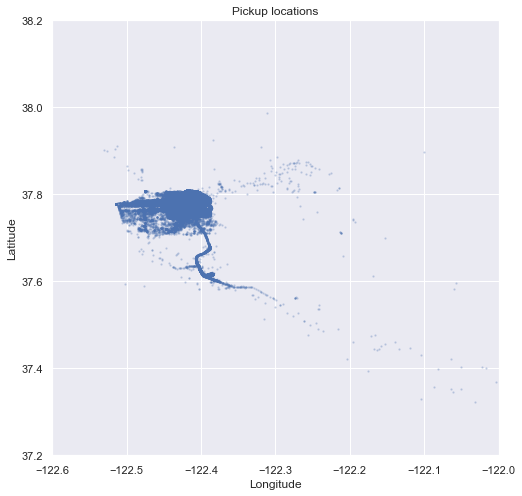

In [215]:
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiOccupiedMorn)

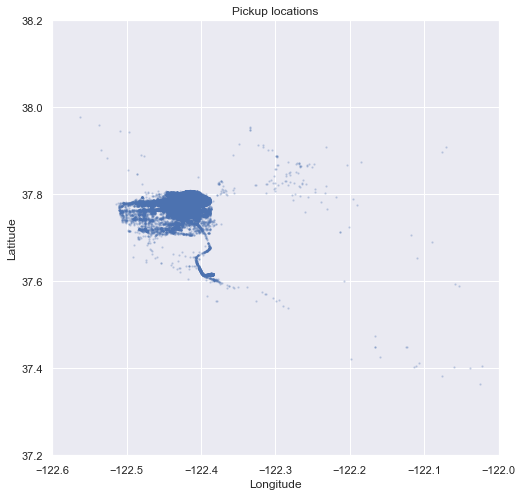

In [216]:
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiOccupiedAft)

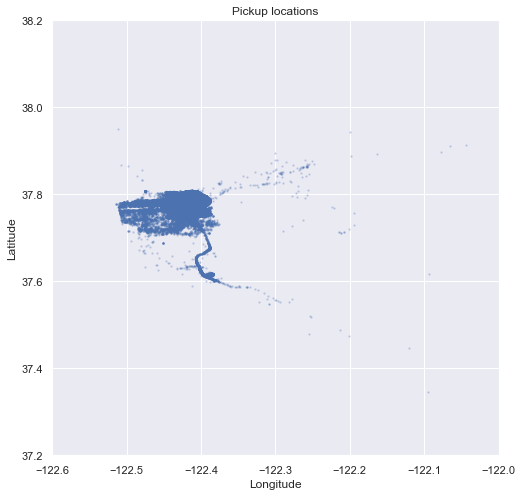

In [217]:
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiOccupiedEvening)

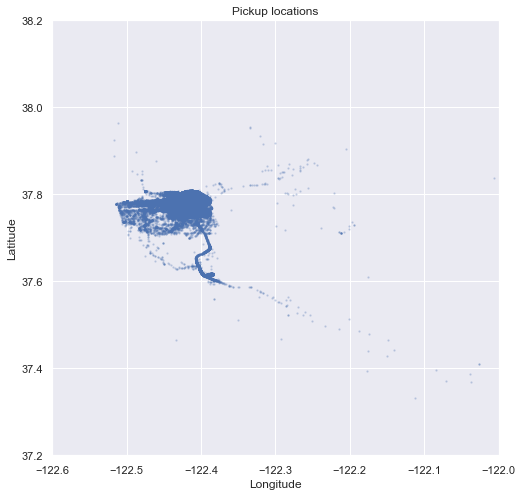

In [218]:
plt.figure(figsize=(8, 8))
pickup_scatter(TaxiOccupiedNight)